### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = '/content/drive/MyDrive/'
except Exception:
    data_dir = './data/'

In [2]:
# You will need to download any word embeddings required for your code, e.g.:

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch

In [123]:
!pip install ekphrasis gensim spacy nltk
!python -m spacy download 'en_core_web_sm'
!python -m spacy download 'en_core_web_lg'

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 778.8 MB 10 kB/s  eta 0:00:0111     |███████████████████▍            | 470.5 MB 99.7 MB/s eta 0:00:04
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# Loading Data

In [3]:
%%bash
export GENSIM_DATA_DIR='./data/'
# python -m gensim.downloader --download glove-twitter-25
# python -m gensim.downloader --download word2vec-google-news-300
# python -m gensim.downloader --download fasttext-wiki-news-subwords-300
# python -m gensim.downloader --download glove-twitter-100

In [121]:
import os
import re
import codecs

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import gensim
import gensim.downloader as api
import spacy
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, random_split
from gensim.models import KeyedVectors

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
# from ekphrasis.dicts.noslang.slangdict

In [5]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [6]:
# Load data
train_df = pd.read_csv(f'{data_dir}/train.csv')
test_df = pd.read_csv(f'{data_dir}/dev.csv')

In [7]:
api.base_dir

'/homes/rrr2417/gensim-data'

In [8]:
train_df.head()

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0


In [9]:
train_df.describe()

,id,grades,meanGrade
count,9652.000000,9.652000e+03,9652.000000
mean,7539.845213,2.048111e+11,0.935571
std,4359.342192,8.211835e+12,0.583643
min,1.000000,0.000000e+00,0.000000
25%,3756.750000,1.110000e+04,0.400000
50%,7510.500000,2.111000e+04,0.800000
75%,11325.250000,3.210000e+04,1.400000
max,15095.000000,3.333332e+14,3.000000


### Analysing Data Distribution and Outliers

In [10]:
grade_std = train_df.meanGrade.std()
grade_mean = train_df.meanGrade.mean()
ub = grade_mean + grade_std * 3
lb = grade_mean - grade_std

train_df[(train_df['meanGrade'] > ub) | (train_df['meanGrade'] < lb)].count()

id           1468
original     1468
edit         1468
grades       1468
meanGrade    1468
dtype: int64

In [11]:
grade_std, grade_mean

(0.5836430877881276, 0.9355712114933001)

In [12]:
train_df[train_df['meanGrade'] >= 2.2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 70 to 9590
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         317 non-null    int64  
 1   original   317 non-null    object 
 2   edit       317 non-null    object 
 3   grades     317 non-null    int64  
 4   meanGrade  317 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 14.9+ KB


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9652 entries, 0 to 9651
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         9652 non-null   int64  
 1   original   9652 non-null   object 
 2   edit       9652 non-null   object 
 3   grades     9652 non-null   int64  
 4   meanGrade  9652 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 377.2+ KB


In [14]:
train_df.meanGrade.unique()

array([0.2       , 1.6       , 1.        , 0.4       , 0.        ,
       1.2       , 0.8       , 1.4       , 0.6       , 1.8       ,
       2.2       , 2.        , 2.4       , 1.3       , 2.06666667,
       0.9       , 2.6       , 0.5       , 2.8       , 1.5       ,
       1.9       , 1.7       , 3.        , 1.1       , 0.7       ,
       2.13333333, 2.5       , 2.1       , 0.86666667, 2.3       ,
       0.3       , 1.33333333, 1.53333333])

In [22]:
train_df.meanGrade.value_counts().sort_index()

0.000000     523
0.200000     928
0.300000       2
0.400000    1100
0.500000       4
0.600000    1166
0.700000       4
0.800000    1186
0.866667       1
0.900000       7
1.000000    1155
1.100000      11
1.200000    1017
1.300000      13
1.333333       1
1.400000     819
1.500000       7
1.533333       1
1.600000     635
1.700000       7
1.800000     430
1.900000       5
2.000000     308
2.066667       1
2.100000       3
2.133333       1
2.200000     167
2.300000       2
2.400000      94
2.500000       1
2.600000      38
2.800000      13
3.000000       2
Name: meanGrade, dtype: int64

<AxesSubplot:>

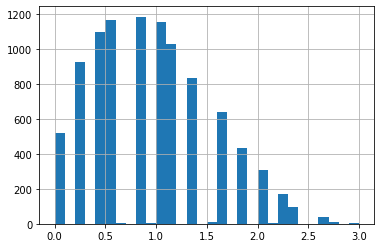

In [16]:
train_df.meanGrade.hist(bins=30)

In [36]:
def remove_outliers(df, ub):
    _df = df.copy()
    return _df[(_df.meanGrade <= ub)]

<AxesSubplot:>

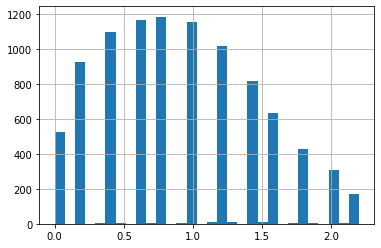

In [39]:
remove_outliers(train_df, ub=2.2).meanGrade.hist(bins=30)

### Preprocessing

In [124]:
nlp = spacy.load('en_core_web_lg')

In [19]:
print('GENSIM LIST OF WORD EMBEDDINGS')
api.info()['models'].keys()

GENSIM LIST OF WORD EMBEDDINGS


dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [16]:
model = KeyedVectors.load_word2vec_format('./data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz')

In [188]:
embeddings = model

#### Ekphrasis Preprocessor

In [22]:
text_processor = TextPreProcessor(
    annotate=['hashtag'],
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="english", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="english", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct=True,  # spell correction for elongated words
)

Reading english - 1grams ...
Reading english - 2grams ...


/vol/bitbucket/rrr2417/deepscm/ENV2/lib/python3.8/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...


#### Some Test Case

In [67]:
fancy_ascii_apostrophe = 0
apostrophe_s = 12
apostrophe_s_2 = 43
contraction_won_t = 48
contraction_won_t_2 = 264
punct_check = 50
contraction_isnt_2 = 66
hashtag = 425 
hashtag2 = 529 
punct_exclaim = 80
punct_question = 27
punct_dash = 26
contraction_dont = 128
contraction_hell = 131
punct_twitter_handle = 4388

test_sentences = [
    fancy_ascii_apostrophe,
    apostrophe_s,
    apostrophe_s_2,
    contraction_won_t,
    contraction_won_t_2,
    punct_check,
    contraction_isnt_2,
    hashtag,
    hashtag2, 
    punct_exclaim,
    punct_question,
    punct_dash,
    contraction_dont,
    contraction_hell,
    punct_twitter_handle,
]

In [68]:
train_df.loc[test_sentences]

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
12,7614,Trump 's 2nd Nominee for <Army/> Secretary Wit...,Class,22100,1.0
43,5732,Fox 's James Murdoch rebukes <Trump/> over Cha...,grits,10000,0.2
48,3274,Kelly wo n't commit to defending DACA in <cour...,space,33100,1.4
264,13786,Franken Reiterates He Wo n't <Resign/> : ' I K...,diet,31111,1.4
50,13443,Rand Paul : Saudi Arabia ’s Role in Backing <T...,Turpentine,10000,0.2
66,7780,This Is n't ' Another Watergate ' But It Plays...,Vaudeville,11000,0.4
425,13225,Steve Bannon <Meets/> with Billionaire Mercer ...,canoodles,21000,0.6
529,3636,China Is Attempting To <Muzzle/> #MeToo,start,0,0.0
80,8947,"Trump to Dems : Of course I colluded , big <de...",time,21000,0.6


#### Merging replacements in the original dataset

In [25]:
edited_sentences = train_df[['original', 'edit']] \
    .apply(lambda x: re.subn("<.*/>", x[1], x[0])[0], axis=1)
edited_sentences.head()

0    France is ‘ hunting down its citizens who join...
1    Pentagon claims 2,000 % increase in Russian tr...
2    Iceland PM Calls Snap Vote as Pedophile Furor ...
3    In an apparent first , Iran and Israel slap ea...
4    Trump was told weeks ago that Flynn misled sch...
dtype: object

#### Removing apostrophes

In [26]:
edited_sentences.str.replace(" (?P<one>\w*'\w+)", lambda x: x.group("one"))[[0, 12, 43, 48, 50, 264, 66]]

<ipython-input-26-649f357cc77e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  edited_sentences.str.replace(" (?P<one>\w*'\w+)", lambda x: x.group("one"))[[0, 12, 43, 48, 50, 264, 66]]


0      France is ‘ hunting down its citizens who join...
12     Trump's 2nd Nominee for Class Secretary Withdraws
43     Fox's James Murdoch rebukes grits over Charlot...
48        Kelly won't commit to defending DACA in space 
50     Rand Paul : Saudi Arabia ’s Role in Backing Tu...
264    Franken Reiterates He Won't diet : ' I Know Th...
66     This Isn't ' Another Watergate ' But It Plays ...
dtype: object

#### Named Entity Recognition (NER)

Pretrained Word2Vec doesn't represent "france" and "France" in the same way (case sensitive). There are many named entities for which this happens which could be problematic if we want to utilities context sensitive representations.

In [135]:
from spacy import displacy 

def ner_viewer(sentence):
    trial_doc = nlp(sentence)

    for ent in trial_doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)

    displacy.render(trial_doc, style="ent", jupyter=True)

In [136]:
ner_viewer(sents.edited_sentences[0])
ner_viewer(sents.edited_sentences[1120])
ner_viewer(sents.edited_sentences[1477])

France 0 6 GPE
Iraq 74 78 GPE


Donald Trump 0 12 PERSON
Twitter 51 58 PRODUCT


Nobel Prize 30 41 WORK_OF_ART


In [47]:
# Analysing similiarty of vectors under google news embeddings
# top 10 similiarities

def similiarities(model, word1, word2, top_n=1000):
    top_words_list = model.similar_by_word(word1, topn=top_n)
    top_words_list2 = model.similar_by_word(word2, topn=top_n)
    top_words_set = set(w for w, sim in top_words_list)
    top_words_set2 = set(w for w, sim in top_words_list2)
    return top_words_list, top_words_list2, top_words_set.intersection(top_words_set2)

In [189]:
simlist1, simlist2, intersection = similiarities(embeddings, 'France', 'france')
intersection

{'-France',
 'AirFrance',
 'Belgium',
 'Belguim',
 'Boulogne',
 'Boulogne-Billancourt',
 'Bretagne',
 'Britain',
 'Britan',
 'Britanny',
 'Brittany',
 'Chateauroux',
 'Europe',
 'France-',
 'France.',
 'Franch',
 'Frence',
 'French',
 'Ile-de-France',
 'Italy',
 'Marseille',
 'Nimes',
 'Paris',
 'Poitou-Charentes',
 'Provence',
 'Spain',
 'Tarbes',
 'Versaille'}

In [190]:
simlist1, simlist2, intersection = similiarities(embeddings, 'Trump', 'trump')
print(simlist1[:10])
print()
print(simlist2[:10])

[('Trumps', 0.7959632873535156), ('Trumpian', 0.7332221269607544), ('Trumping', 0.7272778749465942), ('Trumpism', 0.7086310982704163), ('Drumpf', 0.7022296190261841), ('Trump-like', 0.6928916573524475), ('Anti-Trump', 0.6859002709388733), ('Trump-branded', 0.6830976009368896), ('Trumped', 0.6769288778305054), ('Trump-related', 0.6740255355834961)]

[('trumps', 0.8457010388374329), ('trumping', 0.7876768112182617), ('non-trump', 0.7490019798278809), ('trumped', 0.7124733328819275), ('notrump', 0.6544545888900757), ('supercede', 0.6326020956039429), ('overrule', 0.6288058757781982), ('no-trump', 0.6278952360153198), ('override', 0.6258442401885986), ('supersede', 0.6115215420722961)]


Trump has a different meaning to trump, where the first ones refers to the ex-President and the second is the verb. For this reason, in the context of headlines, we are safer capitalising all words that are named entities, when we are using news-specific pretrained embeddings.

In [31]:
# def tokenize(
#     data, 
#     is_lower=True, 
#     remove_stopwords=True, 
#     remove_puncts=True, 
#     remove_num=True, 
#     remove_currency=True
# ):
#     # Params for 
#     clean_text_param = {
#         "lower":False,                     # lowercase text
#         "no_line_breaks":True,           # fully strip line breaks as opposed to only normalizing them
#         "no_urls":False,                  # replace all URLs with a special token
#         "no_emails":False,                # replace all email addresses with a special token
#         "no_phone_numbers":False,         # replace all phone numbers with a special token
#         "no_numbers":False,               # replace all numbers with a special token
#         "no_digits":False,                # replace all digits with a special token
#         "no_currency_symbols":True,      # replace all currency symbols with a special token
#         "no_punct":True,                 # remove punctuations
#         "replace_with_punct":"",          # instead of removing punctuations you may replace them
#         "replace_with_number":"",
#         "replace_with_digit":"",
#         "replace_with_currency_symbol":"",
#         "lang":"en"                       # set to 'de' for German special handling
#     }

#     text_processor = TextPreProcessor(
#         annotate=['hashtag'],
#         fix_html=True,  # fix HTML tokens
        
#         # corpus from which the word statistics are going to be used 
#         # for word segmentation 
#         segmenter="english", 
        
#         # corpus from which the word statistics are going to be used 
#         # for spell correction
#         corrector="english", 
        
#         unpack_hashtags=True,  # perform word segmentation on hashtags
#         unpack_contractions=True,  # Unpack contractions (can't -> can not)
#         spell_correct=True,
#     )

#     tokenized_corpus = []

#     for sentence in data:

#         tokenized_sentence = []
#         # processed_sentence = text_processor.pre_process_doc(sentence)
#         # clean_sentence = clean(processed_sentence, **clean_text_param)
#         spacy_doc = nlp(sentence)

#         for token in spacy_doc:
#             processed_token = token
#             if (remove_stopwords and processed_token.is_stop):
#                 continue
#             elif (remove_puncts and processed_token.is_punct):
#               continue
#             elif (remove_num and processed_token.is_digit):
#               continue
#             elif (remove_currency and processed_token.is_currency):
#               continue
#             elif (is_lower):
#               tokenized_sentence.append(token.lower_)
#             else:
#               tokenized_sentence.append(token.text)

#         tokenized_corpus.append(tokenized_sentence)

#     return tokenized_corpus

In [59]:
import nltk
from nltk.corpus import stopwords

In [209]:
def capitalisation_by_ner(sentence, entities=['GPE', 'ORG', 'NORP', 'PERSON']):
#     _df = df.copy()

#     for i in df.edited_sentences.index:
    edited_row = []

#         trial_doc = nlp(_df.loc[i, 'edited_sentences'])
        
#         for tok in trial_doc:
#             if tok.ent_type_ in entities:
#                 edited_row.append(tok.text)
#             else:
#                 edited_row.append(tok.text.lower())
                
#         _df.loc[i, 'edited_sentences'] = ' '.join(edited_row)
    
#     return _df
    trial_doc = nlp(sentence)
        
    for tok in trial_doc:
        if tok.ent_type_ in entities:
            edited_row.append(tok.text)
        else:
            edited_row.append(tok.text.lower())
    return ' '.join(edited_row)


def remove_stopwords_and_punct(df):
    nltk.download('stopwords')
    stops = stopwords.words('english')
    
    punct = "[\.,:;\(\)\[\]@\-\$£]"
    
    _df = df.copy()
    
    _df.edited_sentences = _df.edited_sentences \
        .apply(lambda x: " ".join([w for w in x.split(" ") if w not in stops])) \
        # .str.replace(punct, "", regex=True)
    
    return _df

In [210]:
capitalisation_by_ner("I can't do this")

"i ca n't do this"

In [221]:
# Word replacement
# Join the contractions
# Tokenize
# remove stop words
# remove punct EXCEPT ! ? #
# Twitter handles

def preprocess_keep_stopwords(df):
    _df = pd.DataFrame(index=df.index, columns=['edited_sentences', 'meanGrade'])

    _df['meanGrade'] = df.meanGrade

    text_processor = TextPreProcessor(
        fix_html=True,  # fix HTML tokens

        # corpus from which the word statistics are going to be used 
        # for word segmentation 
        segmenter="english", 

        # corpus from which the word statistics are going to be used 
        # for spell correction
        corrector="english", 

        unpack_hashtags=False,  # perform word segmentation on hashtags
        unpack_contractions=False,  # Unpack contractions (can't -> can not)
        spell_correct=True,  # spell correction for elongated words
    )
    punct = "[\.,:;\(\)\[\]@\-\$£]"

    # Word replacement + join the contractions
    # NOTE: need to deal with ' '
    # NOTE: Numbers/digits have not been removed
    # NOTE: We have removed all stop words. We analysed the sentiment of the stop 
    # words in the training set to determine if removing them would negatively 
    # affect our results. The motivation for this check was that any word with a 
    # sentiment would affect the funniness score of the sentence. 
    # Since stop words have no sentiment, they have been removed
    # This doesn't retain any twitter handles, but retains the hashtags

    _df['edited_sentences'] = df[['original', 'edit']] \
        .apply(lambda x: re.subn("<.*/>", x[1], x[0])[0], axis=1) \
        .apply(lambda x: capitalisation_by_ner(x)) \
        .str.replace(" (?P<one>\w*'\w+)", lambda x: x.group("one")) \
        .apply(lambda x: text_processor.pre_process_doc(x)) \
        .str.replace("#", "# ") \
        .str.replace("[‘’]", "'") \
        .str.replace("'s", "") \
        .str.replace(punct, "")

    return _df

In [222]:
sents = preprocess_keep_stopwords(train_df)
sents.loc[test_sentences]

Reading english - 1grams ...


<ipython-input-221-8689799d98f6>:40: FutureWarning: The default value of regex will change from True to False in a future version.
  _df['edited_sentences'] = df[['original', 'edit']] \


,edited_sentences,meanGrade
0,France is ' hunting down its citizens who join...,0.2
12,Trump 2nd nominee for class secretary withdraws,1.0
43,Fox James Murdoch rebukes grits over Charlotte...,0.2
48,Kelly won't commit to defending DACA in space,1.4
264,Franken reiterates he won't diet ' i know tha...,1.4
50,Rand Paul Saudi Arabia role in backing turpe...,0.2
66,this isn't ' another watergate ' but it plays ...,0.4
425,Steve Bannon canoodles with billionaire Mercer...,0.6
529,China is attempting to start # metoo,0.0
80,trump to Dems of course i colluded big time ...,0.6


In [205]:
lower_sents = capitalisation_by_ner(sents)

lower_sents.head(30)

,edited_sentences,meanGrade
0,France is ' hunting down its citizens who join...,0.2
1,Pentagon claims 2000 % increase in Russian tro...,1.6
2,Iceland pm calls snap vote as pedophile furor ...,1.0
3,in an apparent first Iran and Israel slap ea...,0.4
4,Trump was told weeks ago that Flynn misled sch...,0.0
5,all 22 sounds Trump made in his speech to Cong...,1.2
6,new DOJ alert system will flag laughter agains...,1.2
7,as someone who grew up among fundamentalist mo...,1.0
8,Canadians may pay more taxes than Americans ...,0.2
9,Dutch minister resigns in drug baron blow,0.0


###

In [225]:
tokenized_words = sents.edited_sentences.map(lambda x: x.split(" "))
oov_words = []

for sentence in tokenized_words:
    for word in sentence:
        if word not in embeddings.vocab:
            oov_words.append(word)

In [226]:
embeddings

In [227]:
from collections import Counter

oov_words_counter = Counter(oov_words)
print(oov_words_counter)

Counter({'': 7314, "n't": 117, "won't": 64, "don't": 50, "isn't": 35, "can't": 35, "doesn't": 24, "he'll": 15, 'Trumpcare': 15, 'rosenstein': 11, 'metoo': 9, 'manafort': 9, "we'll": 9, 'grenfell': 8, 'comey': 7, 'charlottesville': 7, 'AT&ampT': 7, "DineshD'Souza": 6, "you're": 6, 'Kushners': 6, "shouldn't": 6, "aren't": 6, 'glencore': 6, 'kaspersky': 6, "weren't": 6, "didn't": 6, "couldn't": 6, 'nkorea': 6, "they're": 6, 'cnnpoliticscom': 6, 'apnewsbreak': 5, 'irma': 5, 'tillerson': 5, "BillO'Reilly": 4, 'Manassian': 3, 'Nattering': 3, 'Nabobs': 3, 'deplorableness': 3, 'scalise': 3, 'Recuses': 3, "MartinO'Malley": 3, 'pocohontas': 3, '227000': 3, '138000': 3, 'q&ampa': 3, 'FLYNT': 3, 'Warmbier': 3, 'arbaeen': 3, 'jinping': 3, 'infowarscom': 3, 'Myeshia': 3, 'aesop': 3, 'sh*t': 3, 'gorsuch': 3, 'WomensMarch': 3, 'bigly': 3, 'disinvites': 3, 'covfefe': 3, "hasn't": 3, 'Schlapps': 3, 'Frexit': 3, 'raqqa': 3, 'whcd': 3, 'Nobost': 3, 'DURBIN': 3, "O'Keefe": 3, "wasn't": 3, 'Frightbart': 3, 

In [ ]:
word2vec.similarity("France", "france")

In [ ]:
word2vec.similar_by_word("France", )

In [ ]:
print("don't" in stopwords.words('english'))

In [ ]:
corpus_words = set(" ".join(list(sents.edited_sentences)).split(" "))

In [ ]:
stops = set(stopwords.words('english'))

In [ ]:
exceptions = []

In [ ]:
nltk.download('opinion_lexicon')

In [ ]:
from nltk.corpus import opinion_lexicon
pos_list=set(opinion_lexicon.positive())
neg_list=set(opinion_lexicon.negative())

In [ ]:
print(pos_list)

In [ ]:
inters = corpus_words.intersection(stops)
(inters)

In [ ]:
inters.intersection(pos_list)

In [ ]:
inters.intersection(neg_list)

In [ ]:
stop_words_tokenized = nlp(" ".join(list(inters)))

for token in stop_words_tokenized:
    print("{}   {}".format(token.text, token.sentiment))

In [ ]:
indices = [0, 12, 43, 48, 50, 264, 66, 425, 529, 80, 27, 26, 128, 131, 4388]
for i in indices:
    print(sents.edited_sentences[i])

In [ ]:
punct = "[\.,:;\(\)\[\]@\$£]"

re.sub(punct, "I am @mad", "HELLO")

In [228]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8

In [229]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    
    print("Training model.")

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:

            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            # print(feature)

            predictions = model(feature).squeeze(1)

            optimizer.zero_grad()

            loss = loss_fn(predictions, target)

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

In [230]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [231]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [232]:
train_df['edited_sentence'][264]

KeyError: 'edited_sentence'

In [233]:
tokenized_sents = tokenize([train_df['edited_sentence'][425], train_df['edited_sentence'][48]])

NameError: name 'tokenize' is not defined

In [234]:
sents

,edited_sentences,meanGrade
0,France is ' hunting down its citizens who join...,0.2
1,Pentagon claims 2000 % increase in Russian tro...,1.6
2,Iceland pm calls snap vote as pedophile furor ...,1.0
3,in an apparent first Iran and Israel slap eac...,0.4
4,Trump was told weeks ago that Flynn misled sch...,0.0
...,...,...
9647,state officials blast ' unprecedented ' DHS id...,0.0
9648,protesters rally for stewardesses detained at ...,0.4
9649,cruise line Carnival Corp joins the fight agai...,0.6
9650,Columbia police hunt woman seen with cake near...,1.4


In [ ]:
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list

    for sentence in data:

        tokenized_sentence = []

        for token in sentence.split(' '): # simplest split is

            tokenized_sentence.append(token)

        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

In [ ]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

In [ ]:
class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)

        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)

        out = self.hidden2label(lstm_out[-1])
        return out

In [ ]:
import gensim.downloader as api

In [ ]:
## Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = sents['edited_sentence']
test_data = sents['edited_sentence']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))

print("Vocab created.")

In [ ]:
word2vec = api.load('word2vec-google-news-300')

In [ ]:
"Germany" in word2vec.vocab

In [ ]:
word2vec.get_vector("France")

In [ ]:
word2vec.similar_by_vector(word2vec.get_vector("France") - word2vec.get_vector("france") + word2vec.get_vector("Germany"))

In [ ]:
from collections import Counter

oov_words_counter = Counter(oov_words)
print(oov_words_counter)

In [ ]:
f# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

out_of_

index = 1
for word in joint_vocab:
  if word in word2vec.vocab:
    vec = word2vec.get_vector(word)
    wvecs.append(vec)
    word2idx.append((word, index))
    idx2word.append((index, word))
    index += 1

vector_dim = len(wvecs[0])
wvecs.insert(0, np.zeros(vector_dim))
wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_tokenized_corpus]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

INPUT_DIM = len(word2idx)
EMBEDDING_DIM = wvecs.shape[1]
BATCH_SIZE = 32

model = BiLSTM(EMBEDDING_DIM, 50, INPUT_DIM + 1, BATCH_SIZE, device)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

feature = vectorized_seqs

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())



In [ ]:
train(train_loader, dev_loader, model, epochs)

##### Evaluating the model

In [ ]:
test_df.info()

In [ ]:
vectorized_seqs_test = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in test_tokenized_corpus]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs_test = [x if len(x) > 0 else [0] for x in vectorized_seqs_test]

In [ ]:
test_dataset = Task1Dataset(vectorized_seqs_test, test_df['meanGrade'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

In [ ]:
loss, mse, predictions, target = eval(test_loader, model)
model_performance(predictions, target, print_output=True)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(predictions, bins=30)
plt.hist(target, bins=30, alpha=0.5)
plt.show()

In [ ]:
from sklearn.metrics import explained_variance_score, r2_score

In [ ]:
explained_variance_score(target, predictions)

In [ ]:
r2_score(target, predictions)

In [ ]:
print(min(predictions))
print(max(predictions))
rounded_preds = np.round_(predictions, decimals=1)
print(min(rounded_preds))
print(max(rounded_preds))

In [ ]:
diff = abs(predictions - target)
test_df['predictions'] = predictions
test_df['difference'] = diff
test_df['target'] = target
results_df = test_df[diff > 0.5][['original', 'edit', 'meanGrade', 'predictions', 'target', 'difference']]
results_df

In [ ]:
for i in range(1):
  index = results_df.index[i]
  print(results_df['original'][index], " | ", results_df['edit'][index], " | ", results_df['meanGrade'][index], results_df['predictions'][index])

In [ ]:
np.var(target - predictions)

In [ ]:
train_df['meanGrade'].hist(bins=30)

In [ ]:
test_df[test_df['meanGrade'] >= 2.2]['meanGrade'].hist()

In [ ]:
import seaborn as sns

sns.relplot(x='meanGrade', y='predictions', data=test_df)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
conf = confusion_matrix(target * 10, rounded_preds * 10)
plt.matshow(conf)

In [ ]:
print(classification_report(target * 10, rounded_preds * 10))

In [ ]:
train_and_dev_loader = torch.utils.data.DataLoader(train_and_dev, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

In [ ]:
loss_t, mse_t, predictions_t, target_t = eval(train_and_dev_loader, model)
model_performance(predictions_t, target_t, print_output=True)

In [ ]:
diff_t = abs(predictions_t - target_t)
train_eval_df = train_df.copy(deep=True)
train_eval_df['predictions'] = predictions_t
train_eval_df['difference'] = diff_t
train_eval_df['target'] = target_t

In [ ]:
sns.relplot(x='meanGrade', y='predictions', data=train_eval_df)

In [ ]:
train_eval_df[['meanGrade', 'predictions']].boxplot(by='meanGrade')

In [ ]:
"" in word2vec.vocab

In [ ]:
low_grade = train_eval_df[(train_eval_df['meanGrade'] < 0.3) & (train_eval_df['difference'] >= 1.0)]
low_grade

#### Approach 2: No pre-trained representations

In [ ]:
train_and_dev = train_df['edit']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)

#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)